In [59]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [49]:
# Загрузка данных для бинарной классификации. class - метка для прогноза

PATH_2_TRAIN = "../Датасеты/Грибы/prepared/train.csv"
PATH_2_TEST  = "../Датасеты/Грибы/prepared/test.csv"

data = pd.read_csv(PATH_2_TRAIN)
test_data = pd.read_csv(PATH_2_TEST)

In [50]:
# 1. Энтропия начальной системы для метки class

def entropy(data, column):
    hist = data[column].value_counts()
    return -np.sum(hist / len(data) * np.log2(hist / len(data)))

S0 = entropy(data, "class")
print(S0)

0.9990663240358204


In [51]:
# 2. Разделим данные по признаку cap-shape на две группы

mid = (np.min(data["cap-shape"]) + np.max(data["cap-shape"])) / 2

left = data.loc[data["cap-shape"] <= mid]
right = data.loc[data["cap-shape"] > mid]

S1 = entropy(left, "class")
S2 = entropy(right, "class")

IG = S0 - len(left) / len(data) * S1 - len(right) / len(data) * S2
print(IG)

0.00013839520095104696


In [52]:
# Конструируем дерево решений

columns = list(filter(lambda x : x != "class", data.columns))
X = data[columns].to_numpy(dtype=np.float64)
y = data["class"].to_numpy(dtype=np.int32)

dt = DecisionTreeClassifier(criterion="entropy", random_state=42)
dt.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=42)

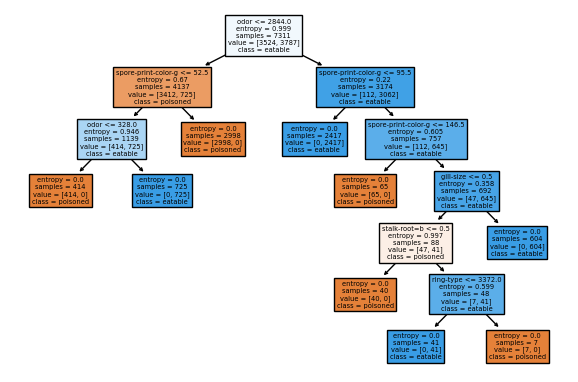

In [53]:
# Рисуем полученное дерево

fig, ax = plt.subplots(figsize=(7.20, 4.80), dpi=100)

plot_tree(dt, feature_names = columns, class_names = ["poisoned", "eatable"],
          filled=True, ax=ax);

In [56]:
# Реализовать IG в виде функции

def entropy(y):
    hist, _ = np.histogram(y, range=(np.min(y), np.max(y)), bins=np.max(y)-np.min(y)+1)
    N = len(y)

    return -np.sum(hist / N * np.log2(hist / N))

def information_gain(root, left, right):
    return entropy(root)                                  \
           - len(left) / len(root) * entropy(left)        \
           - len(right) / len(root) * entropy(right)

def information_gains(X, y):
    res = np.zeros(X.shape[1])
    mid = (np.min(X, axis=0) + np.max(X, axis=0)) / 2

    for i in range(X.shape[1]): # цикл по атрибутам
        res[i] = information_gain(y, y[X[:, i] <= mid[i]], y[X[:, i] > mid[i]])
    return res

print(information_gains(X, y))

[1.38395201e-04 6.66661516e-03 1.88732794e-01 4.53586311e-02
 1.39158382e-02 1.01782031e-01 2.32349211e-01 7.91986611e-03
 1.14835747e-02 1.98049626e-02 3.41805307e-02 1.64770972e-01
 1.06470296e-01 1.68960701e-03 5.48687054e-04 7.79541363e-03
 1.04875764e-03 6.49623192e-02 3.88834253e-02 4.07045847e-02
 3.03279198e-04 3.16122740e-02 2.21700624e-02 1.07881946e-03
 2.59000312e-02 5.52095086e-03 2.13031912e-03 1.93059736e-02
 4.44180539e-03 1.17855235e-02 1.17855235e-02 1.74892829e-02
 4.59563345e-03 8.16145641e-02 7.98960461e-02 9.62140437e-03
 2.16699059e-02 1.55541855e-02 1.07583630e-02 8.30223551e-02
 2.19017701e-02 1.76063427e-02]


In [58]:
# Ещё раз строим дерево и считаем метрику "точность"

tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X, y)

X_test = test_data[columns].to_numpy(dtype=np.float64)
y_test = test_data["class"].to_numpy(dtype=np.int32)

print(accuracy_score(y_test, tree.predict(X_test)))

0.992619926199262


In [60]:
%%time
# Тоже самое, но с подбором гиперпараметра max_depth

tree_params = { "max_depth": range(2, 11) }

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, cv=5)

locally_best_tree.fit(X, y)

Wall time: 427 ms


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17),
             param_grid={'max_depth': range(2, 11)})

In [62]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)
max_depth = locally_best_tree.best_params_["max_depth"];

Best params: {'max_depth': 7}
Best cross validaton score 0.9998632010943911


In [63]:
# Переобучение с лучшим значением max_depth

tuned_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=17)
tuned_tree.fit(X, y)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_predictions)

1.0